## Пример на pyspark

В качестве набора данных для примера будем использовать данные конкурса про ответы студентов на тесты
https://www.kaggle.com/c/riiid-test-answer-prediction

При подключении к spark драйверу установим лимиты по памяти и по числу ядер. Также выберем номер порта для Spark UI

Нужно выбрать уникальное имя приложения и номер порта, чтобы не войти в коллизию с другими пользователями

In [1]:
%pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
import findspark
findspark.init()

In [3]:
from pyspark.sql import SparkSession

spark = (
    SparkSession
        .builder
        .appName("OTUS-Solution")
#         .config("spark.executor.cores", "1")
#         .config("spark.executor.instances", "2")
        .config("spark.dynamicAllocation.enabled", "true")
        .config("spark.executor.memory", "2g")
        .config("spark.driver.memory", "1g")
        .getOrCreate()
)

Данные будем читать из заранее сконвертированного parquet

In [4]:
riiid_df = spark.read.parquet("riiid/train.parquet",)

Схема данных и первые 10 записей

In [5]:
riiid_df.printSchema()

root
 |-- row_id: integer (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- content_id: integer (nullable = true)
 |-- content_type_id: integer (nullable = true)
 |-- task_container_id: integer (nullable = true)
 |-- user_answer: integer (nullable = true)
 |-- answered_correctly: integer (nullable = true)
 |-- prior_question_elapsed_time: double (nullable = true)
 |-- prior_question_had_explanation: boolean (nullable = true)



In [6]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)  # to pretty print pyspark.DataFrame in jupyter
riiid_df.limit(10)

row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
5614100,207493581,119674750,2116,0,91,1,1,5000.0,true
6878464,336625532,149432665,10725,0,127,0,1,8000.0,true
5619667,1717939939,119746920,2412,0,256,0,1,31333.0,true
6008533,16813059434,129559153,6760,0,575,2,0,29000.0,true
5365453,5023058272,114322537,9000,0,182,1,0,29000.0,true
5613270,8950667882,119665027,5758,0,4907,2,1,4000.0,true
7114468,4425457987,154902563,6157,0,2163,1,0,11000.0,true
5347230,4331221769,113727651,10914,0,1273,1,1,36250.0,true
6857182,1819326181,148956176,4696,0,91,0,1,25000.0,false
5648801,598029,120852218,172,0,25,3,0,23000.0,false


Замерим время выполнения простых запросов с группировками

In [7]:
from pyspark.sql import functions as f
from pyspark.sql.functions import col

In [8]:
%%time
(
riiid_df
    .select('content_id', 'answered_correctly')
    .groupby('content_id')
    .mean('answered_correctly')
    .toPandas()
)

CPU times: user 49.3 ms, sys: 697 µs, total: 50 ms
Wall time: 11.5 s


,content_id,avg(answered_correctly)
0,5156,0.471056
1,4519,0.488080
2,3749,0.627472
3,496,0.754256
4,148,0.829767
...,...,...
13777,7466,0.880503
13778,12916,0.932099
13779,12991,0.775362
13780,3406,0.901408


In [9]:
%%time
(
riiid_df
    .select('user_id', 'answered_correctly')
    .groupby('user_id')
    .mean('answered_correctly')
    .toPandas()
)

CPU times: user 1.18 s, sys: 54.4 ms, total: 1.24 s
Wall time: 12.4 s


,user_id,avg(answered_correctly)
0,179127027,0.481013
1,200701357,0.752060
2,192418825,0.515625
3,180704272,0.730108
4,172577204,0.721591
...,...,...
393651,594585110,0.166667
393652,1079675503,0.588235
393653,1074363508,0.707317
393654,1073896135,0.588235


## Упражнение 1
Выведите top 10 студентов с наилучшими результатами

In [11]:
%%time
(
riiid_df
    .select("user_id", "answered_correctly")
    .groupBy("user_id")
    .mean("answered_correctly")
    .orderBy("avg(answered_correctly)", ascending=False)
    .limit(10)
    .toPandas()
)

CPU times: user 11.5 ms, sys: 0 ns, total: 11.5 ms
Wall time: 17.9 s


,user_id,avg(answered_correctly)
0,452224820,1.0
1,1231833900,1.0
2,310907133,1.0
3,289081218,1.0
4,711895126,1.0
5,1943621634,1.0
6,2091007262,1.0
7,794153836,1.0
8,122687953,1.0
9,537004263,1.0


## Упражнение 2
Выведите top 10 задач с наихудшими результатами

In [12]:
%%time
(
riiid_df
    .select("content_id", "answered_correctly")
    .filter(col("answered_correctly") >= 0)
    .groupBy("content_id")
    .mean("answered_correctly")
    .orderBy("avg(answered_correctly)", ascending=True)
    .limit(10)
    .toPandas()
)

CPU times: user 8.28 ms, sys: 4.47 ms, total: 12.8 ms
Wall time: 9.11 s


,content_id,avg(answered_correctly)
0,10007,0.000000
1,1485,0.000000
2,1486,0.000000
3,1484,0.000000
4,10062,0.091752
5,7639,0.100607
6,3125,0.135965
7,9220,0.144753
8,7487,0.147680
9,10924,0.148775


## pyspark user defined functions (UDF)

Как и для других языков, поддерживаемых Spark, для python есть возможность использовать UDF. При этом возникают дополнительные накладные расходы по сравнению с Java и Scala на маршалинг данных.

In [13]:
from pyspark.sql.types import LongType

def to_months(ms):
    return ms // 31536000000 // 12 #1 year = 31536000000 ms

to_months_udf = f.udf(to_months, LongType())

Замерим время выполнения без UDF

In [14]:
%%time
(
    riiid_df
        .select("content_id", "timestamp")
        .groupby("content_id")
        .mean("timestamp")
        .toPandas()
)

CPU times: user 37 ms, sys: 357 µs, total: 37.4 ms
Wall time: 18.8 s


,content_id,avg(timestamp)
0,4818,6.142197e+09
1,2866,1.018793e+10
2,1591,7.811043e+09
3,4519,5.839084e+09
4,7253,1.050513e+10
...,...,...
13777,12444,1.813421e+10
13778,12622,1.211629e+10
13779,13100,1.862596e+10
13780,12991,1.700667e+10


Применим простой UDF к похожему запросу

In [15]:
%%time
(
    riiid_df
        .select("content_id", to_months_udf("timestamp").alias("months"))
        .groupBy("content_id")
        .mean("months")
        .toPandas()
)

CPU times: user 55.1 ms, sys: 4.63 ms, total: 59.8 ms
Wall time: 49.4 s


,content_id,avg(months)
0,4818,0.0
1,2866,0.0
2,1591,0.0
3,4519,0.0
4,7253,0.0
...,...,...
13777,3406,0.0
13778,12622,0.0
13779,12991,0.0
13780,7476,0.0


Перепишем логику, которая была в UDF

In [16]:
%%time
(
     riiid_df
        .select("content_id", (col("timestamp") / 31536000000 / 12).alias("months"))
        .groupby("content_id")
        .mean("months")
        .toPandas()
)

CPU times: user 30.7 ms, sys: 3.93 ms, total: 34.7 ms
Wall time: 12.9 s


,content_id,avg(months)
0,5156,0.018064
1,4519,0.015430
2,3749,0.018309
3,496,0.020155
4,148,0.017911
...,...,...
13777,13100,0.049219
13778,6153,0.007385
13779,12991,0.044940
13780,3406,0.006092


## Упражнение 4
Потсройте гистограмму по числу месяцев до первого взаимодействия студента с заданием

In [17]:
days_histogram = riiid_df.select(col('timestamp') / 31536000000 / 12).rdd.flatMap(lambda x: x).histogram(100)

In [18]:
import numpy as np

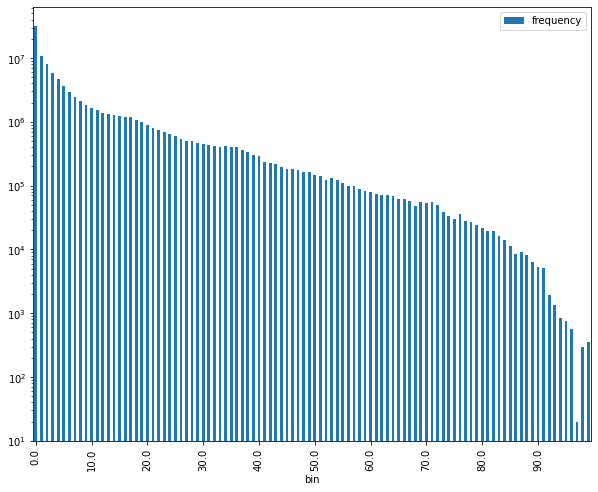

In [19]:
ax = pd.DataFrame(
    list(zip(*days_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar', figsize=(10,8))
ax.set_yscale('log')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, tick_num: np.round(x, 2)))

## Упражнение 5
В файле "riiid/lectures.csv" хранится информация об лекциях. Объедините эту таблицу с основным набором данных при условии, что content_type_id == 1.

In [20]:
lectures = spark.read.csv("riiid/lectures.csv", header=True, inferSchema=True)

In [21]:
lec_df = (
    riiid_df.
        where(f.col("content_type_id") == 1).
        join(lectures, riiid_df.content_id == lectures.lecture_id, 'left')
)

In [22]:
%%time
(
lec_df
    .groupBy("tag")
    .count()
    .orderBy("count", ascending=False)
    .limit(10)
    .toPandas()
)

CPU times: user 8.76 ms, sys: 347 µs, total: 9.11 ms
Wall time: 14.2 s


,tag,count
0,62,58869
1,27,52826
2,163,41668
3,136,41483
4,161,39884
5,26,38777
6,170,35855
7,94,34115
8,1,31699
9,73,30706
